In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

import time
import os
import copy

# Logging time, process
from tqdm import tqdm



class ConvModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        
        '''
            Define a basic convolution module (Conv + Relu):
            stripe = 1, padding = same (1)
        '''
        self.conv = torch.nn.Conv2d(in_channels  = in_channels, 
                                    out_channels = out_channels, 
                                    kernel_size  = kernel_size, 
                                    stride  = stride,
                                    padding = padding)
    def forward(self, x):
        return F.relu(self.conv(x))


In [17]:
class InceptionModule(torch.nn.Module):
    def __init__(self,  in_channels, out_channels):
        super().__init__()
        
        '''
            Define an Inception module - a concatenation of:
            - ConvModule(1)
            - ConvModule(1) - ConvModule(3)
            - ConvModule(1) - ConvModule(5)
            - MaxPooling - ConvModule(1)
            
            * out_channels: List of out_channels of each branch
            
        '''
        
        self.conv1 = ConvModule(in_channels, out_channels[0], kernel_size=1, stride=1, padding=0)
        
        self.conv3_1 = ConvModule(in_channels, out_channels[1], kernel_size=1, stride=1, padding=0)
        self.conv3_3 = ConvModule(out_channels[1], out_channels[2], kernel_size=3, stride=1, padding=1)
        
        self.conv5_1 = ConvModule(in_channels, out_channels[3], kernel_size=1, stride=1, padding=0)
        self.conv5_5 = ConvModule(out_channels[3], out_channels[4], kernel_size=5, stride=1, padding=2)
        
        self.pool4   = torch.nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
        self.conv_max_1 = ConvModule(in_channels, out_channels[5], kernel_size=1, stride=1, padding=0)
        
    
    def forward(self, x):
        
        branch1 = self.conv1(x)
        
        branch2 = self.conv3_1(x)
        branch2 = self.conv3_3(branch2)
            
        branch3 = self.conv5_1(x)
        branch3 = self.conv5_5(branch3)
        
        branch4 = self.pool4(x)
        branch4 = self.conv_max_1(branch4)
        
        out = [branch1, branch2, branch3, branch4]
        
        return torch.cat(out, 1)

In [18]:
class InceptionNet(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        
        '''
        Define an Inception v1 Net with 22 layers
        - Input   : 224x224x3
        
        - Relu(Conv(k=7,s=2,c=64))
        - MaxPool(k=3,s=2)
        - Relu(Conv(k=1,s=1,c=64))
        - Relu(Conv(k=3,s=2,c=192))
        - MaxPool(k=3,s=2)
        
        - Inception(192, [64, 96, 128, 16, 32, 32])
        - Inception(256, [128, 128, 192, 32, 96, 64])
        - Inception(480, [192, 96, 208, 16, 48, 64])
        - Inception(512, [160, 112, 224, 24, 64, 64])
        - Inception(512, [128, 128, 256, 24, 64, 64])
        - Inception(512, [112, 144, 288, 32, 64, 64])
        - Inception(528, [256, 160, 320, 32, 128, 128])
        - Inception(832, [256, 160, 320, 32, 128, 128])
        - Inception(832, [384, 192, 384, 48, 128, 128])
        
        - AvgPool(k=7, s = 1)
        - FC(1024, 2)
        
        https://josephpcohen.com/w/visualizing-cnn-architectures-side-by-side-with-mxnet/
        https://mega.nz/#!4RJE1SSY!kcCDyhkum6EQqVtqTc-deHnQuckM3zYSYq16bADbfww
    '''
        self.conv1 = ConvModule(3, 64, kernel_size=7, stride=2, padding=3)
        self.pool1 = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.conv2 = ConvModule(64, 64, kernel_size=1, stride=1, padding=0)
        self.conv3 = ConvModule(64, 192, kernel_size=3, stride=1, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.inception_3a = InceptionModule(192, [64, 96, 128, 16, 32, 32])
        self.inception_3b = InceptionModule(256, [128, 128, 192, 32, 96, 64])
        self.pool3 = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.inception_4a = InceptionModule(480, [192, 96, 204, 16, 48, 64])
        self.inception_4b = InceptionModule(508, [160, 112, 224, 24, 64, 64])
        self.inception_4c = InceptionModule(512, [128, 128, 256, 24, 64, 64])
        self.inception_4d = InceptionModule(512, [112, 144, 288, 32, 64, 64])
        self.inception_4e = InceptionModule(528, [256, 160, 320, 32, 128, 128])
        self.pool4 = torch.nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.inception_5a = InceptionModule(832, [256, 160, 320, 48, 128, 128])
        self.inception_5b = InceptionModule(832, [384, 192, 384, 48, 128, 128])
        self.pool5 = torch.nn.AvgPool2d(kernel_size = 7, stride = 1, padding = 0)
        
        self.fc = torch.nn.Linear(1024*1*1, 1000)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.inception_3a(x)
        x = self.inception_3b(x)
        x = self.pool3(x)
        x = self.inception_4a(x)
        x = self.inception_4b(x)
        x = self.inception_4c(x)
        x = self.inception_4d(x)
        x = self.inception_4e(x)
        x = self.pool4(x)
        x = self.inception_5a(x)
        x = self.inception_5b(x)
        x = self.pool5(x)
        
        x = x.view(-1, 1024*1*1)
        x = self.fc(x)
        return x

In [19]:
checkpoint = torch.load("data/inception_v1_weights.pth", map_location='cpu')
import collections
converted_state = collections.OrderedDict()

for layer in checkpoint.keys():
    if "conv" in layer:
        key = layer.split(".")
        key = ['.'.join(key[:-1]), 'conv', key[-1]]
        key = '.'.join(key)
        converted_state[key] = checkpoint[layer]
    else:
        converted_state[layer] = checkpoint[layer]
        
model = InceptionNet()
model.load_state_dict(converted_state)

In [20]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

dataset = datasets.ImageFolder("data/cat_dog", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
data_label_mapping = dataset.class_to_idx
data_label_mapping = {data_label_mapping[label]: label for label in data_label_mapping}

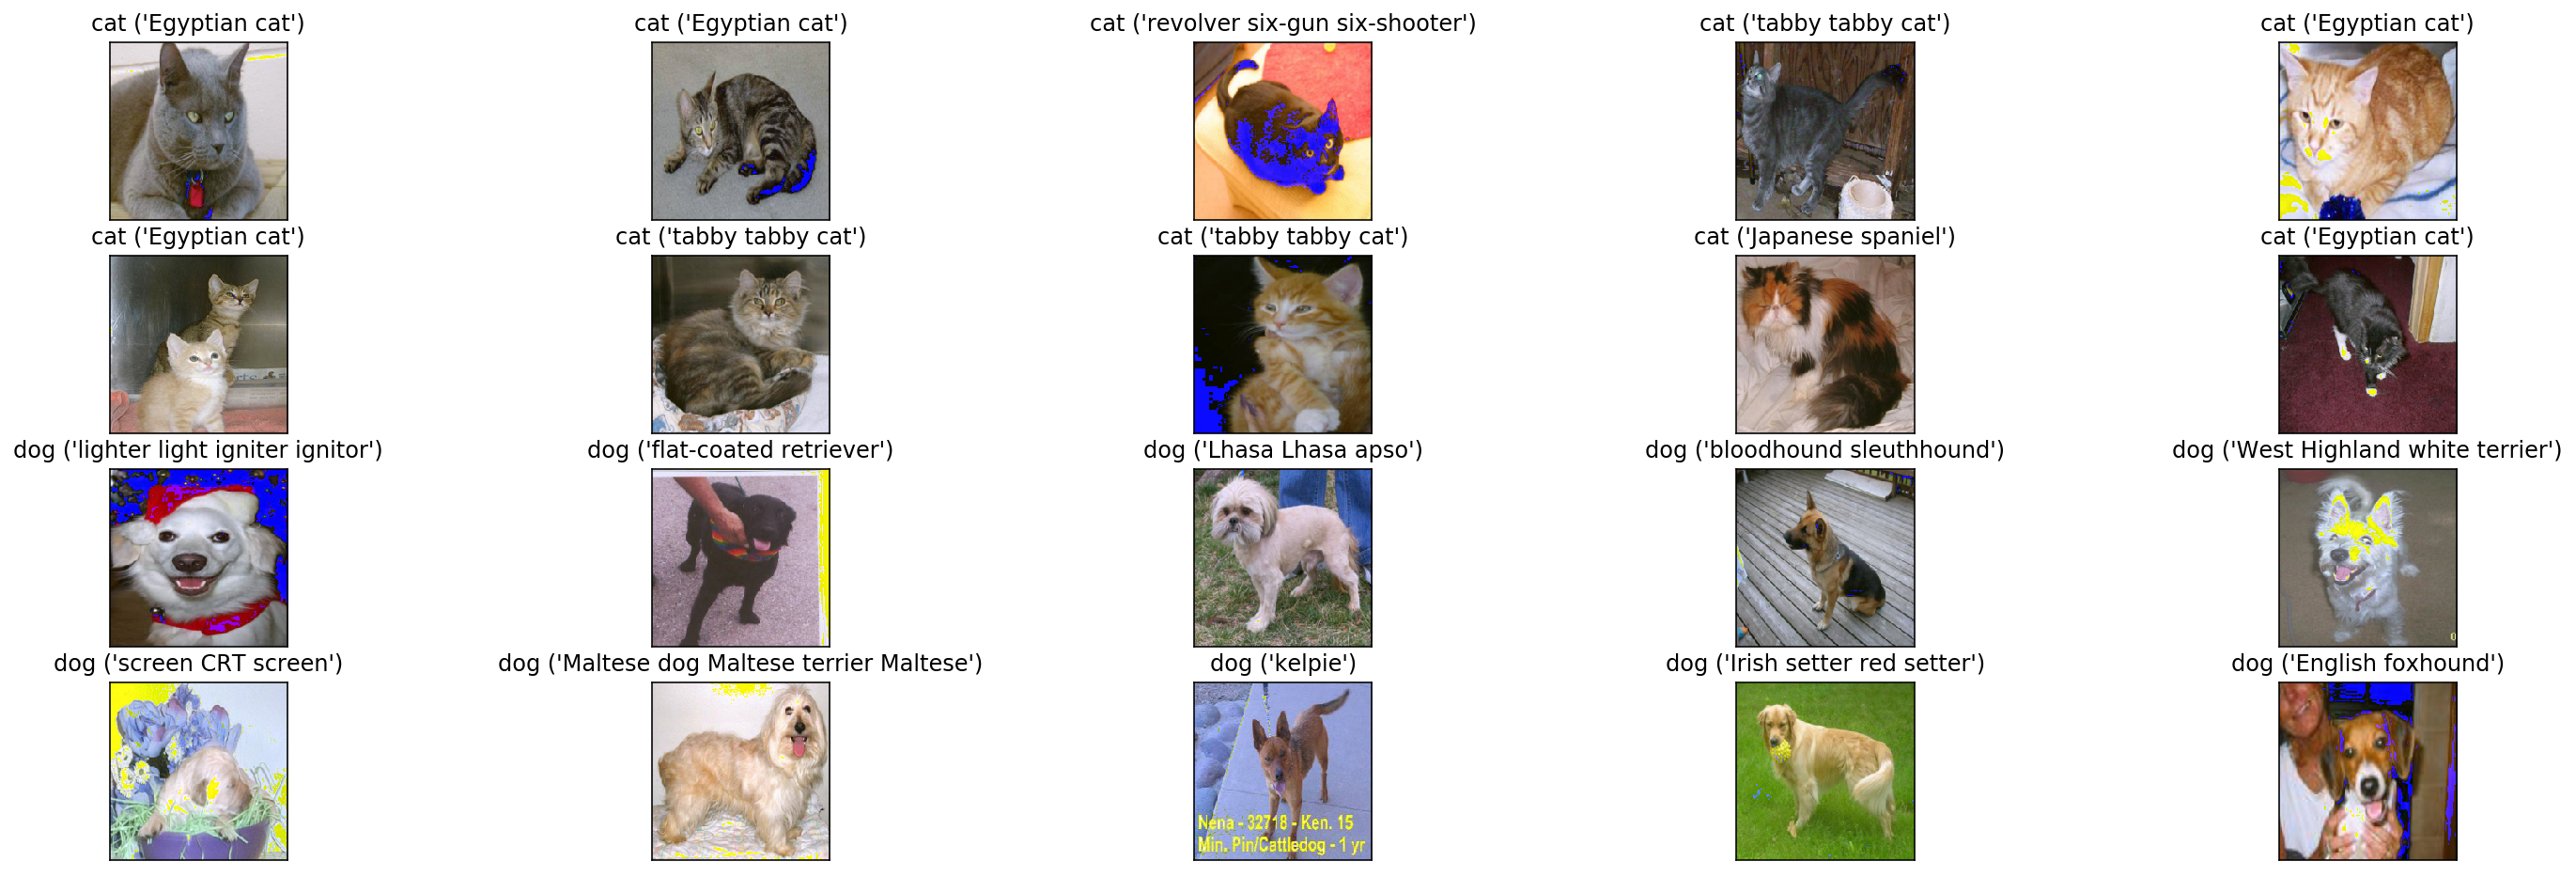

In [21]:
import json
with open('data/imagenet1000_clsidx_to_labels.json', ) as f:
    imnet_label_mapping = json.load(f)
    imnet_label_mapping = {int(label): imnet_label_mapping[label] for label in imnet_label_mapping}
    
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

fig = plt.figure(figsize=(25, 8))

for idx, data in enumerate(dataloader):
    image, label = data
    with torch.no_grad():
        model.eval()
        log_ps = model(image)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1) # Get top 1 class
        
        ax = fig.add_subplot(4, 20/4, idx+1, xticks=[], yticks=[])
        image = inv_normalize(image[0])
        image = image.numpy().transpose((1, 2, 0))
        plt.imshow(image)
        ax.set_title("{} ({})".format(data_label_mapping[int(label)], imnet_label_mapping[int(top_class)]))
            